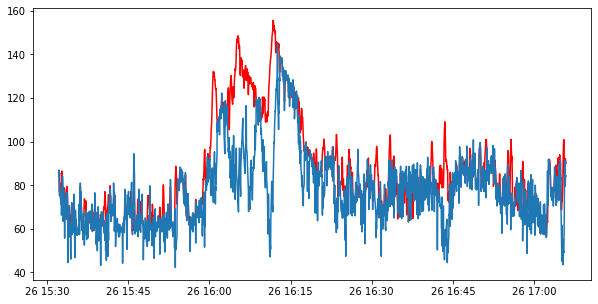

9.743697581111249


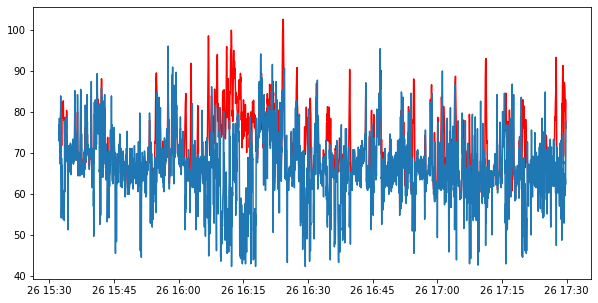

6.580793523122591


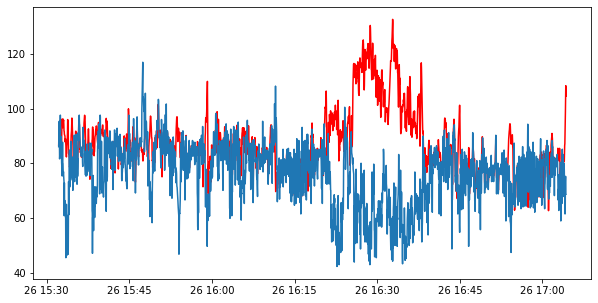

13.075601901889431


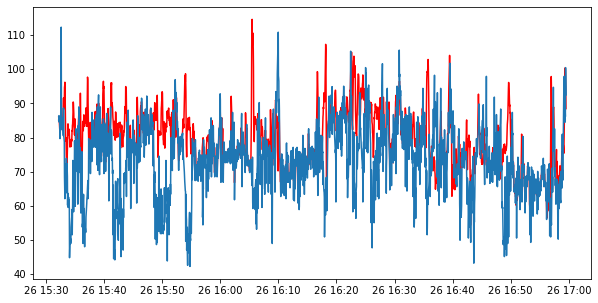

8.708147142136701


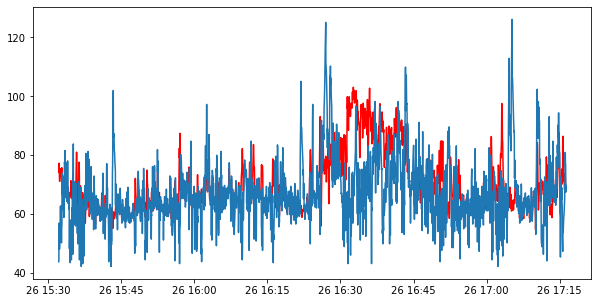

8.226420783881462


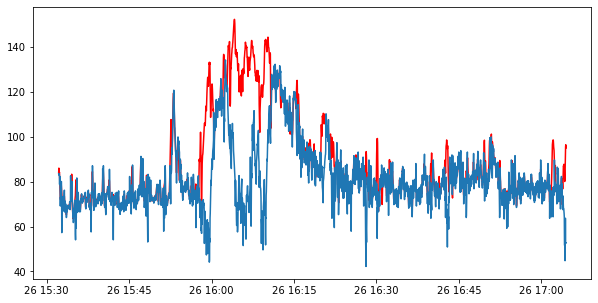

8.788614875776462


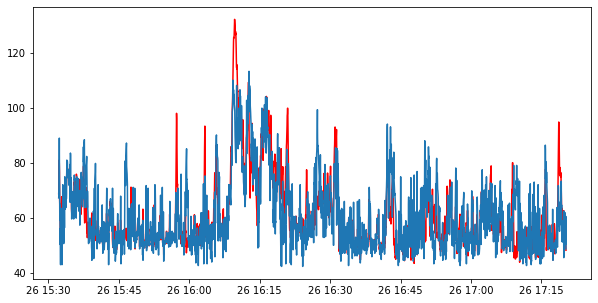

6.087246149113608


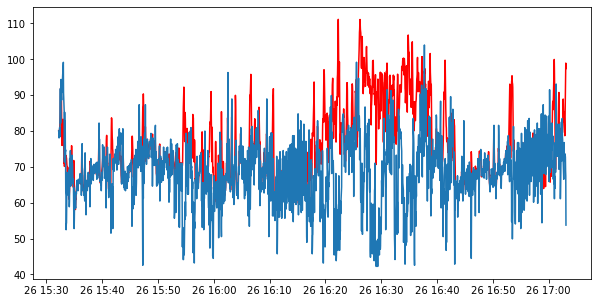

8.897416540552403


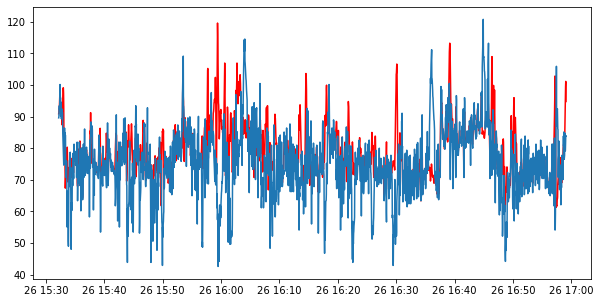

7.223834399067641


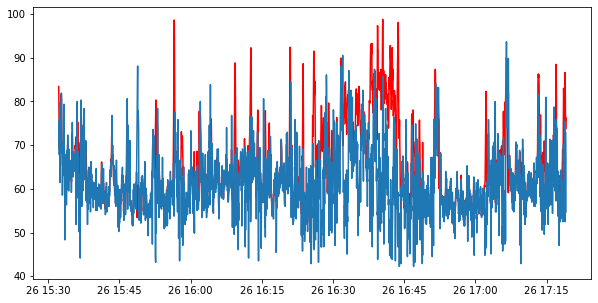

5.623175729858731


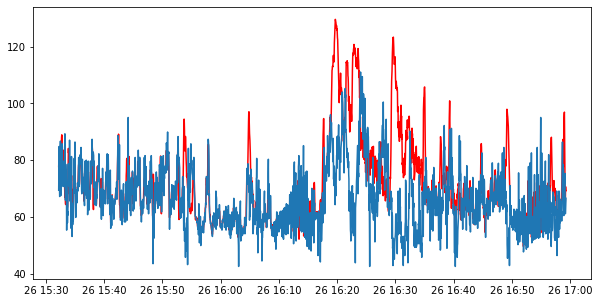

8.949986927930894


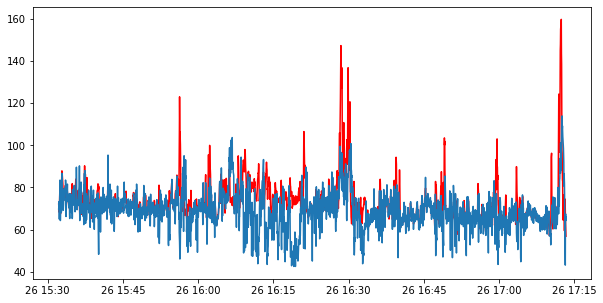

6.974520826284553


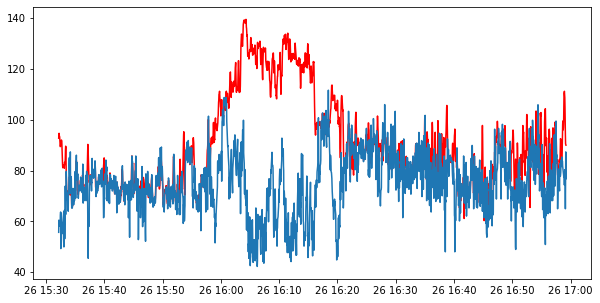

16.45036669099886


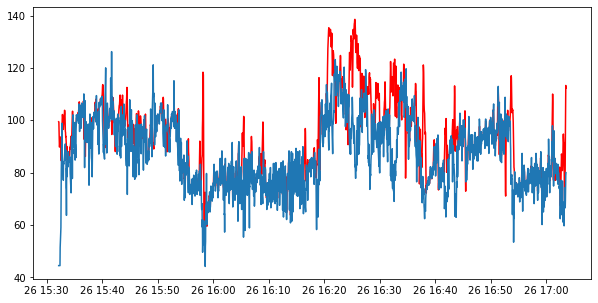

7.290120232215724


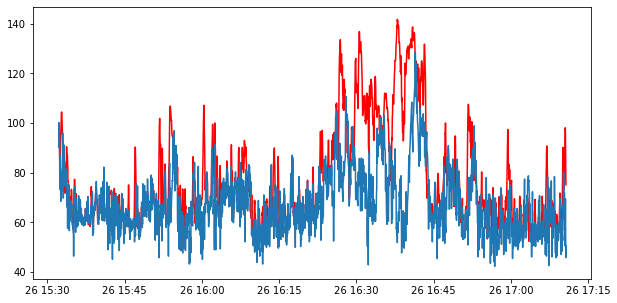

11.631715258098735
8.950110570802602 2.7835485621371276


In [26]:
import pickle
import numpy as np
import pandas as pd
import os
%matplotlib inline
filelists = ['../../ppg_quality_aware_hr/data/8/'+a for a in os.listdir('../../ppg_quality_aware_hr/data/8/') if a[-1] not in ['s','f']]

import warnings
warnings.filterwarnings('ignore')
from scipy import signal
from peakdetect1 import peakdetect
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from scipy.signal import find_peaks
plt.close('all')
def filter_data(X,
                Fs=64,
                low_cutoff=.5,
                high_cutoff=3.0,
                filter_order=1):
    """
    Bandpass Filter of single channel

    :param X: input data
    :param Fs: sampling freq.
    :param low_cutoff: low passband
    :param high_cutoff: high passband
    :param filter_order: no of taps in FIR filter

    :return: filtered version of input data
    """
    X1 = X.reshape(-1,1)
    X1 = signal.detrend(X1,axis=0,type='constant')
    b = signal.firls(filter_order,np.array([0,low_cutoff-.1, low_cutoff, high_cutoff ,high_cutoff+.5,Fs/2]),np.array([0, 0 ,1 ,1 ,0, 0]),
                     np.array([100*0.02,0.02,0.02]),fs=Fs)
    X2 = signal.convolve(X1.reshape(-1),b,mode='same')
    return X2

class heart_rate:
    def __init__(self,lower_hr_range=.7,higher_hr_range=3.5,height=.2):
        self.hr_now = 0
        self.history_hr = []
        self.lower_hr_range = lower_hr_range
        self.higher_hr_range = higher_hr_range
        self.height = height
        self.previous = 0
        self.step = 2
    
    def filter_frequencies(self,x_x,f_x,pxx_x):
        x_x = np.array(x_x)
        x_x = x_x[f_x[x_x]>self.lower_hr_range]
        x_x = x_x[f_x[x_x]<self.higher_hr_range]
        f_x = f_x[x_x]
        pxx_x = pxx_x[x_x]
        return f_x,pxx_x
    
    def get_peaks(self,data,fs,nperseg,nfft):
        f_x, pxx_x = signal.welch(data,fs=fs,nperseg=nperseg,nfft=nfft)
        f_x = f_x.reshape(-1)
        pxx_x = pxx_x/np.max(pxx_x)
        x_x, _ = find_peaks(pxx_x, height=self.height)
        f,pxx = self.filter_frequencies(x_x,f_x,pxx_x)
        ppg = np.array(list(zip(f,pxx)))
        if len(ppg)==0:
            return []
        ppg = ppg[ppg[:,1].argsort()]
        return ppg
    
    def get_rr_value(self,values,acc_window,ecg_rr,Fs=64,nfft=12000):
        """
        Get Mean RR interval

        :param values: single channel ppg data
        :param Fs: sampling frequency
        :param nfft: FFT no. of points
        :return: Mean RR interval Information
        """
        values = filter_data(values)
        ppg = self.get_peaks(values,Fs,values.shape[0],nfft)[-3:]
        
        if len(ppg)==0:
            if len(self.history_hr)==0:
                return 0
            self.hr_now = np.mean(self.history_hr)
            self.history_hr.append(self.hr_now)
            self.history_hr  =self.history_hr[-6:]
            return 60000/self.hr_now
        
        aclx = list(self.get_peaks(acc_window[:,0],Fs//2,acc_window.shape[0],nfft)[-1:])
        acly = list(self.get_peaks(acc_window[:,1],Fs//2,acc_window.shape[0],nfft)[-1:])
        aclz = list(self.get_peaks(acc_window[:,2],Fs//2,acc_window.shape[0],nfft)[-1:])
#         print(ppg)
        acl_unwanted = np.array(aclx+acly+aclz)
        if len(acl_unwanted)>0:
            acl_unwanted = acl_unwanted[:,0]*60
            hr_now = 0
            for k in range(1,len(ppg)+1):
                hr_temp = ppg[-1*k,0]*60
                if len(acl_unwanted[np.where((acl_unwanted>hr_temp-self.step)&(acl_unwanted<hr_temp+self.step))[0]])==0:
                    hr_now = hr_temp
                    break
#             print(hr_now,'done')
        else:
            hr_now = ppg[-1,0]*60
        
        if hr_now==0:
            hr_now = ppg[-1,0]*60
        

        if not self.hr_now:
            self.hr_now = hr_now
            self.history_hr.append(self.hr_now)
            self.history_hr  =self.history_hr[-6:]
            return 60000/self.hr_now
        else:
            if abs(self.hr_now-hr_now)>15:
                if self.previous>5:
                    self.history_hr.append(hr_now)
                    self.hr_now = np.mean(self.history_hr)
                    self.history_hr.append(self.hr_now)
                    self.history_hr  =self.history_hr[-6:]
                    self.previous=1
                    return 60000/self.hr_now
                else:
                    self.hr_now = np.mean(self.history_hr)
                    self.history_hr.append(self.hr_now)
                    self.history_hr = self.history_hr[-6:]
                    self.previous+=1
                    return 60000/self.hr_now
                    
            else:
                self.hr_now = hr_now
                self.history_hr.append(self.hr_now)
                self.history_hr  =self.history_hr[-6:]
                return 60000/self.hr_now
                

        

from datetime import datetime
from sklearn.metrics import mean_absolute_error
error = []
for f in filelists:
    data = pickle.load(open(f,'rb'))
    data['timestamp'] = data['start_time'].apply(lambda a:datetime.utcfromtimestamp(a))
#     data['ppg_rr'] = data.apply(lambda a:get_rr_value(a['data'].sort_values('time').reset_index(drop=True)['ppg'].values,
#                                                  a['acc_window'][a['acc_window'][:,0].argsort(),1:],a['ecg_rr']*1000),axis=1)
    hr = heart_rate()
    ppg_rr_col = []
    for i,a in data.iterrows():
        ppg_rr_col.append(hr.get_rr_value(a['data'].sort_values('time').reset_index(drop=True)['ppg'].values,
                                        a['acc_window'][a['acc_window'][:,0].argsort(),1:],
                                        a['ecg_rr']*1000))
        
        
    data['ppg_rr'] = ppg_rr_col
    data = data[data['ppg_rr']>0]
    data['ecg_rr'] = data['ecg_rr'].apply(lambda a: 60/a)
    data['ppg_rr'] = data['ppg_rr'].apply(lambda a: 60000/a)
    error.append(mean_absolute_error(data['ecg_rr'],data['ppg_rr']))
    import matplotlib.pyplot as plt
    plt.close('all')
    plt.figure(figsize=(10,5))
    data = data[data['ppg_rr']>0]
    # plt.scatter(data['ecg_rr'],data['ppg_rr'])
    plt.plot(data['timestamp'],data['ecg_rr'],'r')
    plt.plot(data['timestamp'],data['ppg_rr'])
    # plt.plot(data['timestamp'],data['label']*1000)
    plt.show()
    print(error[-1])
print(np.mean(error),np.std(error))
# plt.scatter(data['ecg_rr'],data['ppg_rr'])
#     plt.plot(data['timestamp'],data['ecg_rr']*1000,'r')
#     plt.plot(data['timestamp'],data['ppg_rr'])
#     plt.plot(data['timestamp'],data['label']*1000)
#     plt.show()
#     ppg_windows = [df for i,df in data.groupby(pd.Grouper(key='timestamp',freq='60S'))]

In [14]:
# data = data[data.label.isin([1])]
data.head()
# data

,start_time,end_time,data,respiration,ecg_rr,inspiration_duration,expiration_duration,respiration_duration,acc_window,label,timestamp,ppg_rr
0,1.608997e+09,1.608997e+09,time ppg skew kurtosis ...,"[[-1.742034474721677], [-1.7430258663701088], ...",95.188283,1.222143,1.516429,2.738571,"[[1608996731.917987, -0.75, -0.640625, 0.09375...",0.0,2020-12-26 15:32:11.917987,90.240
1,1.608997e+09,1.608997e+09,time ppg skew kurtosis ...,"[[-0.168834740705831], [-0.17316854252194233],...",97.204913,1.253333,1.580000,2.833333,"[[1608996733.917987, -0.78125, -0.640625, 0.09...",0.0,2020-12-26 15:32:13.917987,100.160
2,1.608997e+09,1.608997e+09,time ppg skew kurtosis ...,"[[0.84749853440041], [0.8495930225304722], [0....",99.257257,1.242500,1.557143,2.799643,"[[1608996735.917987, -0.34375, 0.921875, 0.218...",0.0,2020-12-26 15:32:15.917987,85.440
3,1.608997e+09,1.608997e+09,time ppg skew kurtosis ...,"[[-1.4961125144846938], [-1.4903044627371504],...",98.219106,1.244762,1.571429,2.816191,"[[1608996737.917987, -0.453125, 0.90625, 0.109...",0.0,2020-12-26 15:32:17.917987,81.152
4,1.608997e+09,1.608997e+09,time ppg skew kurtosis ...,"[[-0.9864867998016653], [-0.9892650255904902],...",93.541203,1.211071,1.548929,2.760000,"[[1608996739.917987, -0.515625, 0.875, 0.0625]...",0.0,2020-12-26 15:32:19.917987,76.832


<IPython.core.display.Javascript object>


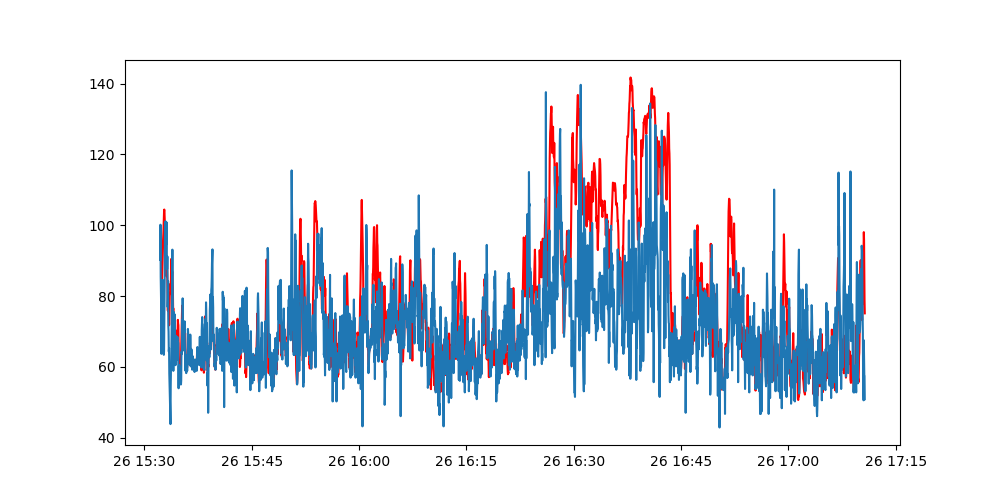

In [15]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.close('all')
plt.figure(figsize=(10,5))
# data = data[data['ppg_rr']>0]
# plt.scatter(data['ecg_rr'],data['ppg_rr'])
plt.plot(data['timestamp'],data['ecg_rr'],'r')
plt.plot(data['timestamp'],data['ppg_rr'])
# plt.plot(data['timestamp'],data['label']*1000)
plt.show()

In [ ]:
from peakdetect1 import peakdetect

In [ ]:
data['data'].loc[0]

In [ ]:
data['acc_window'][0].shape